In [35]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pre_processing.textProcessing import TextPreProcessor
import nltk
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
# nltk.download('omw-1.4')

### Read Data

In [7]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
test_labels = pd.read_csv('../data/test_labels.csv')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Initial EDA

In [5]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
print('Number of Labels by Label')
train.iloc[:, 2:].sum()

Number of Labels by Label


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

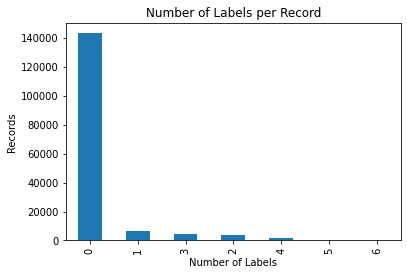

In [9]:
# Check for records that have multiple classifications
classified = train.iloc[:, 2:].sum(axis=1)

mult_class = classified.value_counts()

mult_class.plot(x=mult_class, 
             y=mult_class.values, 
             kind='bar', 
             xlabel='Number of Labels', 
             ylabel='Records')
plt.title('Number of Labels per Record')

pass

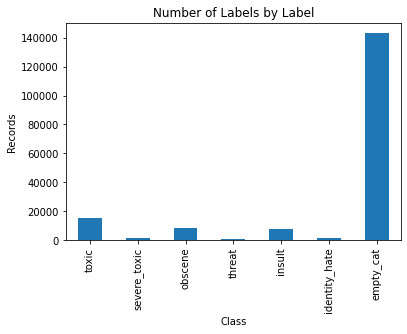

In [10]:
# Check for records that have no classifications and data imbalance
train['empty_cat'] = (classified == 0)
train['empty_cat'] = train['empty_cat'].astype(int)
 
cat_tot = train.iloc[:, 2:].sum()

cat_tot.plot(x=cat_tot, 
             y=cat_tot.values, 
             kind='bar', 
             xlabel='Class', 
             ylabel='Records')
plt.title('Number of Labels by Label')

pass

# Data Preprocessing

### Imbalanced Data: Create Sample

Create a training sample of the following groupings to correct for data imbalance. Split in to 30% for each grouping.

* **Toxic** - Records with classifications that include 'toxic' label.
* **No Toxic** - Records with classifications that do not fall under 'toxic' label.
* **Empty** - Records with no classifications

In [11]:
toxic = train[(train.toxic == 1) & (train.empty_cat == 0)]
no_toxic = train[(train.toxic == 0) & (train.empty_cat == 0)]
empty = train[(train.empty_cat == 1)]

print('Total Toxic records: ', toxic.shape[0])
print('Total No Toxic records: ', no_toxic.shape[0])
print('Total Empty records: ', empty.shape[0])

Total Toxic records:  15294
Total No Toxic records:  931
Total Empty records:  143346


In [12]:
toxic = train[(train.toxic == 1) & (train.empty_cat == 0)]
no_toxic = train[(train.toxic == 0) & (train.empty_cat == 0)]
empty = train[(train.empty_cat == 1)]

sample = pd.concat([toxic[:900], no_toxic[:900], empty[:900]], 
                    ignore_index=True)

sample.shape

(2700, 9)

### Process text for feature-based modeling
1. Process each document
2. Turn the documents into a Document-term matrix

In [13]:
def tokenize(text):
    """
    Define a function that take in a text and process the doc
    """
    return TextPreProcessor(text=text, lemma_flag=True, stem_flag=False).process()

### Count Vectorizer

In [15]:
doc = sample.comment_text

In [16]:
# Fit the Count vectorizer
vec_count = CountVectorizer(ngram_range=(1,1),tokenizer=tokenize, min_df=15, max_df=0.9)
vec_count_f = vec_count.fit(doc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [17]:
dtm = vec_count_f.transform(doc)
dtm_df = pd.DataFrame(dtm.toarray())
dtm_df.columns = vec_count_f.get_feature_names()

In [18]:
dtm_df

,able,absolutely,abuse,abusive,academic,accept,access,accord,account,accurate,...,wow,wp,write,wrong,wtf,yeah,year,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF Vectorizer

In [19]:
doc = sample.comment_text

In [20]:
vec_tfidf = TfidfVectorizer(ngram_range=(1,1),tokenizer=tokenize, min_df=15, max_df=0.9)
vec_tfidf_f = vec_count.fit(doc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [21]:
vect = vec_tfidf_f.transform(doc)
vect_df = pd.DataFrame(vect.toarray())
vect_df.columns = vec_tfidf_f.get_feature_names()

In [22]:
vect_df.head()

,able,absolutely,abuse,abusive,academic,accept,access,accord,account,accurate,...,wow,wp,write,wrong,wtf,yeah,year,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Process for Recurrent Neural Network
1. Process each doc
2. Turn each doc into a numeric representation
3. Do Padding

In [23]:
doc = sample.comment_text

In [24]:
# processed_docs = [tokenize(x) for x in doc]
processed_docs = doc.map(lambda x: tokenize(x))

# Create the tokenizer for NN processing
t = Tokenizer()
# Fit the tokenizer on the documents
t.fit_on_texts(processed_docs)
# Transform docs into numeric rep
encoded_docs = t.texts_to_sequences(processed_docs)

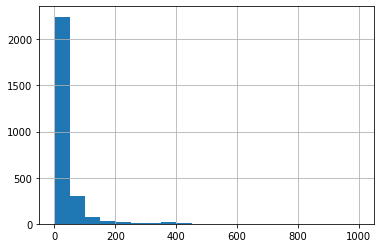

In [25]:
# Find the optimal lengths for padding
pd.Series(encoded_docs).apply(lambda x: len(x)).hist(bins = 20);

In [27]:
max_len = 150 # Most of the documents are less than length 150
padded_doc = pad_sequences(encoded_docs, maxlen = max_len, padding = 'post')

In [28]:
# Print example
print("---Original text---")
print(doc[0])

print('\n---Processed text---')
print(processed_docs[0])

print('\n---Encoded text---')
print(encoded_docs[0])

print('\n---Padded text---')
print(padded_doc[0])

---Original text---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

---Processed text---
['cocksucker', 'piss', 'around', 'work']

---Encoded text---
[184, 418, 126, 77]

---Padded text---
[184 418 126  77   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [30]:
pd.DataFrame(padded_doc).head(100)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,184,418,126,77,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,204,18,2552,360,488,5997,61,929,5998,5999,...,0,0,0,0,0,0,0,0,0,0
2,1565,32,31,19,3087,70,2553,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,144,6003,3952,434,3953,3954,6004,3088,135,49,...,0,0,0,0,0,0,0,0,0,0
4,1,1938,225,2207,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11,333,134,35,888,12,21,77,205,11,...,0,0,0,0,0,0,0,0,0,0
96,82,4043,21,99,507,5,306,17,2244,59,...,0,0,0,0,0,0,0,0,0,0
97,4044,4044,5,1189,1754,122,6234,6235,13,28,...,0,0,0,0,0,0,0,0,0,0
98,6238,444,2209,14,48,6239,334,2599,6240,6241,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(padded_doc, 
                                                  sample.iloc[:, 2:8], 
                                                  test_size=0.15, 
                                                  random_state=0)

# Baseline Model: Naive Bayes

In [32]:
NBclassifier = MultinomialNB()

for i in Y_train:
    NBclassifier.fit(X_train, Y_train[i])
    pred = NBclassifier.predict(X_val)
    acc = accuracy_score(Y_val[i], pred)
    print(f'{i} Accuracy: {acc}')

toxic Accuracy: 0.4666666666666667
severe_toxic Accuracy: 0.5703703703703704
obscene Accuracy: 0.5555555555555556
threat Accuracy: 0.3925925925925926
insult Accuracy: 0.4024691358024691
identity_hate Accuracy: 0.37037037037037035


In [ ]:
# For exploring cross validation

# score = cross_val_score(classifier, X_train, Y_train[i], scoring='accuracy')

# Test FNN Model

Single hidden layer FNN

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=3, activation='relu'))

model.add(tf.keras.layers.Dense(units=6, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='Adam',
              metrics=['accuracy'])

2022-07-17 16:00:17.406876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
history = model.fit(x = X_train,
                    y = Y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(X_val, Y_val),
                    verbose=1
                   )

Epoch 1/5
36/36 [==============================] - 1s 6ms/step - loss: 941.2927 - accuracy: 0.1425 - val_loss: 487.8580 - val_accuracy: 0.2420
Epoch 2/5
36/36 [==============================] - 0s 2ms/step - loss: 314.4842 - accuracy: 0.3203 - val_loss: 187.6471 - val_accuracy: 0.4025
Epoch 3/5
36/36 [==============================] - 0s 2ms/step - loss: 133.0185 - accuracy: 0.4331 - val_loss: 88.5471 - val_accuracy: 0.4889
Epoch 4/5
36/36 [==============================] - 0s 2ms/step - loss: 62.5764 - accuracy: 0.2824 - val_loss: 49.3827 - val_accuracy: 0.1654
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 32.7328 - accuracy: 0.1765 - val_loss: 27.1724 - val_accuracy: 0.1630


### Confusion Matrix